<a href="https://colab.research.google.com/github/anasrasyid/Final-Project-Computer-Vision-Course/blob/master/tensorflow_object_detection_faster_rcnn_on_UNO_card_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Training Faster R-CNN Object Detection on a UNO Card dataset**






Our notebook based on this [colab notebook](https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn). And Dataset used in this notebook hosted in [roboflow](https://public.roboflow.com/object-detection/uno-cards)

## Installation Tensorflow GPU v1.15 and other library

In [ ]:
!pip install tensorflow_gpu==1.15

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install numpy==1.19.5
!pip uninstall -y pycocotools
!pip install pycocotools --no-binary pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: pycocotools 2.0.4
Uninstalling pycocotools-2.0.4:
  Successfully uninstalled pycocotools-2.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pycocotools-2.0.4.tar.gz (106 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=265200 sha256=855e825663ba1f376c259505585e77f29b04d4cb334b74b958a7cf89fb1f84a8
  Stored in directory: /root/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744b3bba59b
Successfully built pycocotools


## Configs and Hyperparameters
We'll be training a Faster R-CNN neural network. Faster R-CNN is a two-stage detector: first it identifies regions of interest, and then passes these regions to a convolutional neural network. The outputted features maps are passed to a support vector machine (SVM) for classification. Regression between predicted bounding boxes and ground truth bounding boxes are computed.

In [ ]:
# If you forked the repo, you can replace the link.
repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.
num_steps = 10000  # 200000 to improve --> 10000

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'faster_rcnn_inception_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Clone the `tensorflow-object-detection` repository and installation

In [ ]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'tensorflow-object-detection-faster-rcnn'...
remote: Enumerating objects: 885, done.
remote: Total 885 (delta 0), reused 0 (delta 0), pack-reused 885
Receiving objects: 100% (885/885), 24.83 MiB | 22.23 MiB/s, done.
Resolving deltas: 100% (428/428), done.
/content/tensorflow-object-detection-faster-rcnn
Already up to date.


### Install required packages

In [ ]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib pycocotools tf_slim

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
Selecting previously unselected package python-bs4.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa

## Prepare `tfrecord` files (dataset)

We'll be using an open source cell dataset called Uno Card Dataset (Detection Card-Types). Our dataset contains 8892 images is hosted publicly on Roboflow [here](https://public.roboflow.com/object-detection/uno-cards).

In [ ]:
%cd /content/tensorflow-object-detection-faster-rcnn/data

/content/tensorflow-object-detection-faster-rcnn/data


In [ ]:
# UPDATE THIS LINK - get our data from Roboflow
dataset_link = ...
!curl -L {dataset_link} > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   4206      0 --:--:-- --:--:-- --:--:--  4206
100  324M  100  324M    0     0   180M      0  0:00:01  0:00:01 --:--:--  238M
Archive:  roboflow.zip
 extracting: test/Card-Types.tfrecord  
 extracting: train/Card-Types.tfrecord  
 extracting: valid/Card-Types.tfrecord  
 extracting: test/Card-Types_label_map.pbtxt  
 extracting: train/Card-Types_label_map.pbtxt  
 extracting: valid/Card-Types_label_map.pbtxt  
 extracting: README.roboflow.txt     
 extracting: README.dataset.txt      


In [ ]:
%ls

FYI.txt  README.dataset.txt  README.roboflow.txt  test/  train/  valid/


In [ ]:
# check out what we have in train
%ls train

Card-Types_label_map.pbtxt  Card-Types.tfrecord


In [ ]:
# show what we have in test
%ls test

Card-Types_label_map.pbtxt  Card-Types.tfrecord


In [ ]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
test_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/valid/Card-Types.tfrecord'
train_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/Card-Types.tfrecord'
label_map_pbtxt_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/Card-Types_label_map.pbtxt'

## Creating Model and Pipeline

In this section, we create model based on base model in tensorflow pretrained and creating pipeline to train that model. The model arechitecture is one of many available via TensorFlow's [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models).

### Download base model

In [ ]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [ ]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 111M
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 .
drwxr-xr-x 23 root   root 4.0K Jun 28 01:55 ..
-rw-r--r--  1 345018 5000   77 Feb  1  2018 checkpoint
-rw-r--r--  1 345018 5000  55M Feb  1  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 5000  51M Feb  1  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 5000  16K Feb  1  2018 model.ckpt.index
-rw-r--r--  1 345018 5000 5.5M Feb  1  2018 model.ckpt.meta
-rw-r--r--  1 345018 5000 3.2K Feb  1  2018 pipeline.config
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 saved_model


In [ ]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

### Configuring a Training Pipeline

In [ ]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [ ]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [ ]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [ ]:
!cat {pipeline_fname}

# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 15
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        tr

In [ ]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

### Load Tensorboard




In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

## Train the model

In [ ]:
!pip install lvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0628 01:56:38.533649 139709999802240 model_lib.py:839] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 10000
I0628 01:56:38.533868 139709999802240 config_util.py:552] Maybe overwriting train_steps: 10000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0628 01:56:38.533962 139709999802240 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0628 01:56:38.534045 139709999802240 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0628 01:56:38.534123 139709999802240 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0628 01:56:38.534226 139709999802240 model_lib.py:855] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to

In [ ]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1656381445.c10c728f5f8a
export
graph.pbtxt
model.ckpt-10000.data-00000-of-00001
model.ckpt-10000.index
model.ckpt-10000.meta
model.ckpt-8447.data-00000-of-00001
model.ckpt-8447.index
model.ckpt-8447.meta
model.ckpt-8950.data-00000-of-00001
model.ckpt-8950.index
model.ckpt-8950.meta
model.ckpt-9452.data-00000-of-00001
model.ckpt-9452.index
model.ckpt-9452.meta
model.ckpt-9954.data-00000-of-00001
model.ckpt-9954.index
model.ckpt-9954.meta


## Training Result

Final Evaluation Results

 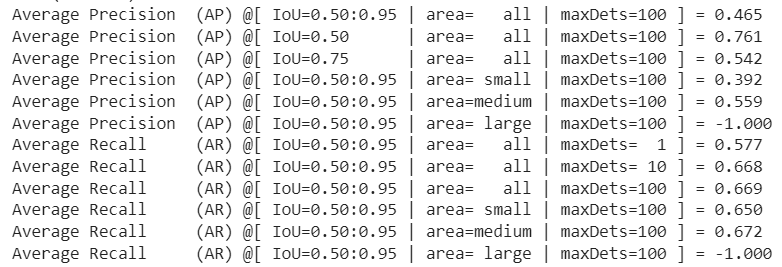

Loss for final step: 0.5284869.

In [ ]:
%tensorboard --logdir {model_dir}

Reusing TensorBoard on port 6006 (pid 854), started 3:18:18 ago. (Use '!kill 854' to kill it.)

## Exporting a Trained Inference Graph
Once training job is complete, extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [ ]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-10000
Instructions for updating:
Please use `layer.__call__` method instead.
W0628 05:17:39.763754 140388710725504 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:2802: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Scale of 0 disables regularizer.
I0628 05:17:40.962348 140388710725504 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
I0628 05:17:41.078584 140388710725504 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0628 05:17:41.078976 140388710725504 convolutional_box_predictor.py:155] depth of additional conv before box predictor: 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0628 05:17:41.134630

In [ ]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


### Download the model `.pb` file

In [ ]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [ ]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 51M Jun 28 05:17 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


In [ ]:
from google.colab import files
files.download(pb_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Download the `label_map.pbtxt` file

In [ ]:
from google.colab import files
files.download(label_map_pbtxt_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Run inference test

To test  our model, we need to upload raw test images to the `test` folder located inside `/data`.

Right now, this folder contains TFRecord files from Roboflow. We need the raw images.


In [ ]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/content/models/research/object_detection


In [ ]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [ ]:
# This is needed to display the images.
%matplotlib inline

In [ ]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "data/test")
TEST_IMAGE_PATHS = PATH_TO_TEST_IMAGES_DIR
assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
if len(TEST_IMAGE_PATHS) == 0:
  sample_img = 'https://storage.googleapis.com/roboflow-platform-transforms/Ly2DeBzbwsemGd2ReHk4BFxy8683/cf5ed147e4f2675fbabbc9b0db750ecf/transformed.jpg'
  import urllib.request
  urllib.request.urlretrieve(sample_img, 
                            PATH_TO_TEST_IMAGES_DIR + "/cell.jpg")

TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(len(TEST_IMAGE_PATHS))

['/content/tensorflow-object-detection-faster-rcnn/data/test/000390579_jpg.rf.d1b2fa00021cc4f2c8e1b332783fe1d3.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/006431818_jpg.rf.1d81de238d72a3119fe5299a12a25dcc.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/010208206_jpg.rf.2cf74070874439a010ce26bb7cc733ca.jpg']


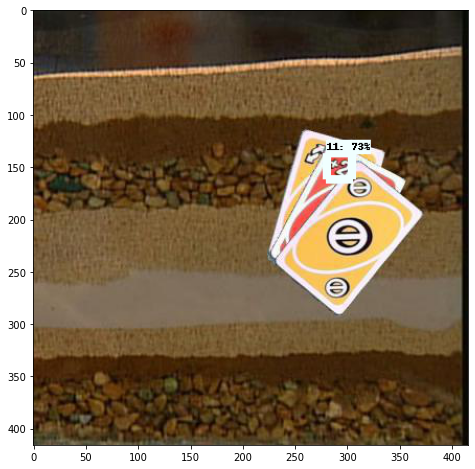

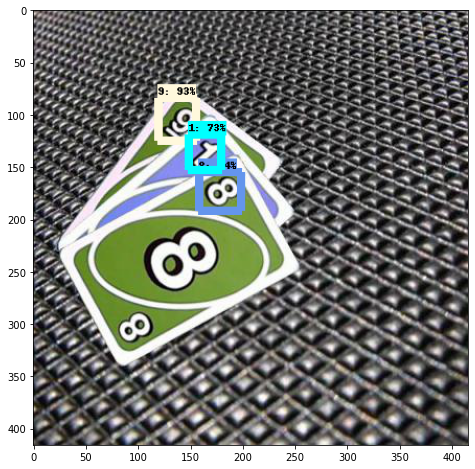

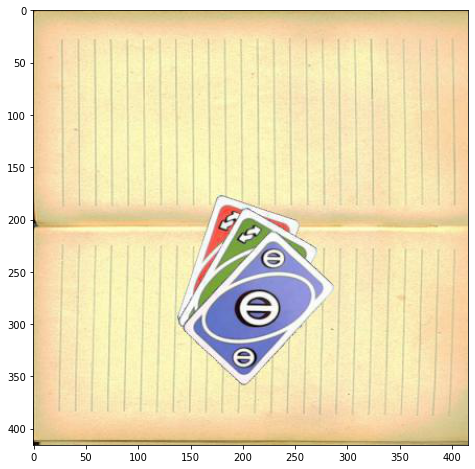

In [ ]:
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)